In [7]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
chrom = '7'
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene_w':'./data/gene/non_gene_'+chrom+'.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam1234567':'./data/051_1234567.bam',
    'bam4':'./data/051_4.bam'
    }

fasta = ps.FastaFile(dic['fasta'])
bamfile = ps.AlignmentFile(dic['bam1234567'],'rb')
gene = []
with open(dic['gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in [chrom]:
            gene.append([ll[0],int(ll[1]),int(ll[2])])


In [8]:
gene = sorted(gene, key= lambda x: x[1])
non_gene = []
for i, gg in enumerate(gene):
    if i == 0 or i == len(gene) - 1:
        continue
    start = gg[1] - 4000
    end = gg[1] - 2000
    if start > gene[i-1][2]:
        if 'N' not in fasta.fetch('chr'+chrom,start,end):
            non_gene.append([chrom, start, end])
    start = gg[2] + 2000
    end = gg[2] + 4000
    if end < gene[i+1][1]:
        if 'N' not in fasta.fetch('chr'+chrom,start,end):
            non_gene.append([chrom, start, end])



In [9]:
with open(dic['non_gene_w'],'w') as f:
    for region in non_gene:
        f.write("{}\t{}\t{}\n".format(region[0],region[1],region[2]))

In [10]:
coverage = np.zeros((len(non_gene),2000),dtype = int)
# long_array = np.zeros((len(non_gene), 2000), dtype=int)
# short_array = np.zeros((len(non_gene), 2000), dtype=int)
for i, region in enumerate(non_gene):
    chrom = region[0]
    start = region[1]
    end = region[2]
    for r in bamfile.fetch(chrom, start-1500, end+1500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start or r.reference_start > end:
                continue
            ss = max(0, r.reference_start - start)
            ee = min(r.reference_start - start + abs(r.isize), end - start)
            for p in range(ss, ee):
                coverage[i][p] += 1
            # if abs(r.isize) > 150:
            #     for p in range(ss, ee):
            #         long_array[i][p] += 1
            # else:
            #     for p in range(ss, ee):
            #         short_array[i][p] += 1
    

26.817307692307693 8.13271093145977


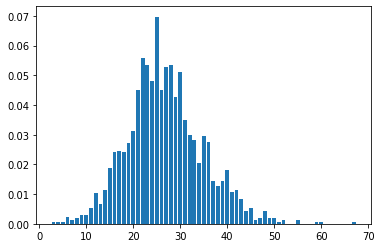

In [11]:
# plt.plot([x for x in range(2000)],[np.mean(long_array[:,x] - short_array[:,x]) for x in range(2000)])
# plt.show()
plt.plot([x for x in range(2000)],[np.mean(coverage[:,x]) for x in range(2000)])
plt.show()
plt.plot([x for x in range(2000)],[np.std(coverage[:,x], ddof=1) for x in range(2000)])
plt.show()
mm = [np.mean(coverage[:,x]) for x in range(2000)]
ss = [np.std(coverage[:,x], ddof=1) for x in range(2000)]
print(mm[1000],ss[1000])
for i in range(995,996):
    qq = []
    for j in range(len(non_gene)):
        qq.append(coverage[j][i])
    dd = {}
    for q in sorted(qq):
        if q in dd:
            dd[q] += 1/len(qq)
        else:
            dd[q] = 1/len(qq)
    x = [ke for ke in dd]
    y = [dd[ke] for ke in dd]
    plt.bar([ke for ke in dd], [dd[ke] for ke in dd])
    plt.show()